In [28]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import warnings
from pathlib import Path
import jax.numpy as jnp
import numpy as np
import pandas as pd

# GPUDrive dependencies
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (7, 2)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 120
warnings.filterwarnings("ignore")

### Configurations

In [29]:
BASE_DIR = "./notebooks/"
SCENARIO_ID = "11671609ebfa3185"

### Load debug scenario and saved samples 

We saved the following inputs from the same scenario:
- Processed VBD inputs (used in waymax)
- Processed VBD inputs (used in gpudrive)

In [30]:
with open(f"{BASE_DIR}waymax_vbd_sample_{SCENARIO_ID}.pkl", "rb") as f:
    waymax_vbd_data = pickle.load(f)

with open(f"{BASE_DIR}gpudrive_vbd_sample_{SCENARIO_ID}.pkl", "rb") as f:
    gpudrive_vbd_data = pickle.load(f)

### Helper functions

In [75]:
def make_heatmaps(waymax_vbd_data, gpudrive_vbd_data, array_name, index, feature_name):
    
    vmin = min(waymax_vbd_data[array_name][:, :, index].min(),
           gpudrive_vbd_data[array_name].squeeze(0)[:, :, index].min())
    vmax = max(waymax_vbd_data[array_name][:, :, index].max(),
            gpudrive_vbd_data[array_name].squeeze(0)[:, :, index].max())
    
    if vmin >= 0:
        cmap = 'Reds'
        center = None
    else:
        cmap = 'bwr'
        center = 0

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)

    # Create the heatmaps without individual color bars
    sns.heatmap(
        waymax_vbd_data[array_name][:, :, index], cmap=cmap, center=center, linewidth=.5,
        vmin=vmin, vmax=vmax, cbar=False, annot=False, ax=axs[0]
    )
    axs[0].set_title("Waymax VBD data")
    axs[0].set_xlabel("Time step")
    axs[0].set_ylabel("Agent index")

    sns.heatmap(
        gpudrive_vbd_data[array_name].squeeze(0)[:, :, index], cmap=cmap, center=center, linewidth=.5,
        vmin=vmin, vmax=vmax, cbar=False, annot=False, ax=axs[1]
    )
    axs[1].set_title("GPUDrive VBD data")

    cbar = fig.colorbar(axs[0].collections[0], ax=axs, orientation="vertical",  pad=0.04)
    cbar.set_label(f"{feature_name}")

    plt.show()

### **Overview**

In [76]:
waymax_vbd_data.keys()

dict_keys(['agents_history', 'agents_interested', 'agents_type', 'agents_future', 'traffic_light_points', 'polylines', 'polylines_valid', 'relations', 'agents_id', 'anchors'])

In [33]:
gpudrive_vbd_data.keys()

dict_keys(['agents_history', 'agents_interested', 'agents_type', 'agents_future', 'traffic_light_points', 'polylines', 'polylines_valid', 'relations', 'agents_id', 'anchors'])

### ❌ 1. Agents history [TODO: needs deep dive]

- What:
    - First $t$ time steps of the log playback trajectories. Used to predict trajectories
- Shape: Number of agents (32), time steps (12), features (8)
- **Summary** of feature comparison:
    - `(x, y)`: ❌*
        - Note:
    - `yaw`: ❌
        - Notes: Why is the GPUDrive yaw always positive? Waymax yaw can be negative. Negative yaw angle usually indicates rotation to the left, so this seems important.
            - ,,

    - `vel_x, vel_y`: ❌*
    - `veh_len, veh_width, veh_height`: ❌

- Checklist:
    - ✔️: Is the order or features aligned? -> yes
    - ✔️: Compare across time and agents
    - _todo_: Find out where diffs come from

---
$*$ Not the same, but these values cannot be compared because we substract the mean in GPUDrive to center these at 0, which is not done in Waymax.

In [56]:
waymax_vbd_data['agents_history'].shape, gpudrive_vbd_data['agents_history'].squeeze(0).shape

((32, 12, 8), (32, 12, 8))

In [57]:
time_step = 0

In [58]:
feature_names = {
    0: "x",
    1: "y",
    2: "yaw",
    3: "velocity_x",
    4: "velocity_y",
    5: "vehicle_length",
    6: "vehicle_width",
    7: "vehicle_height"
}


#### Yaw 

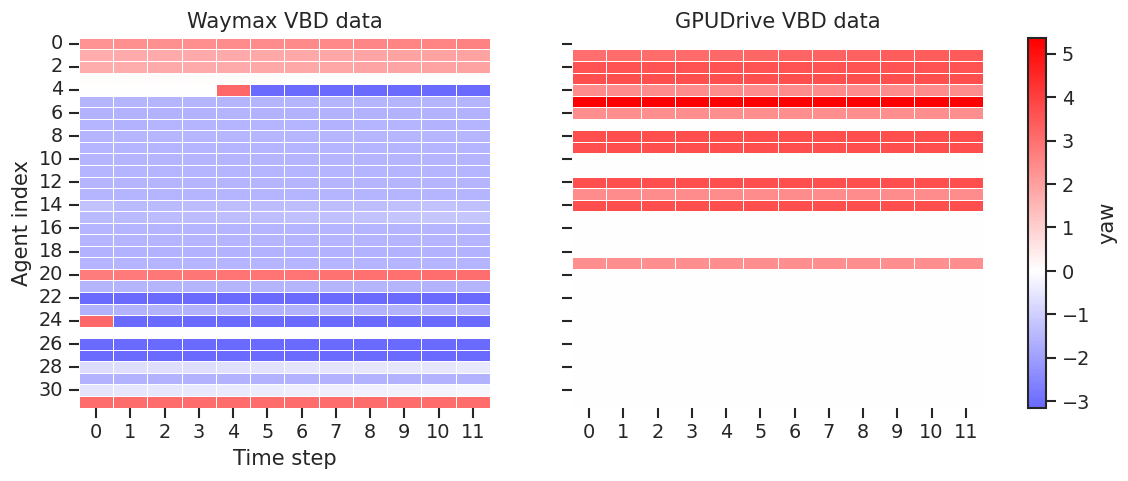

In [78]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_history',
    index=2, 
    feature_name=feature_names[2]
)

#### Vehicle length

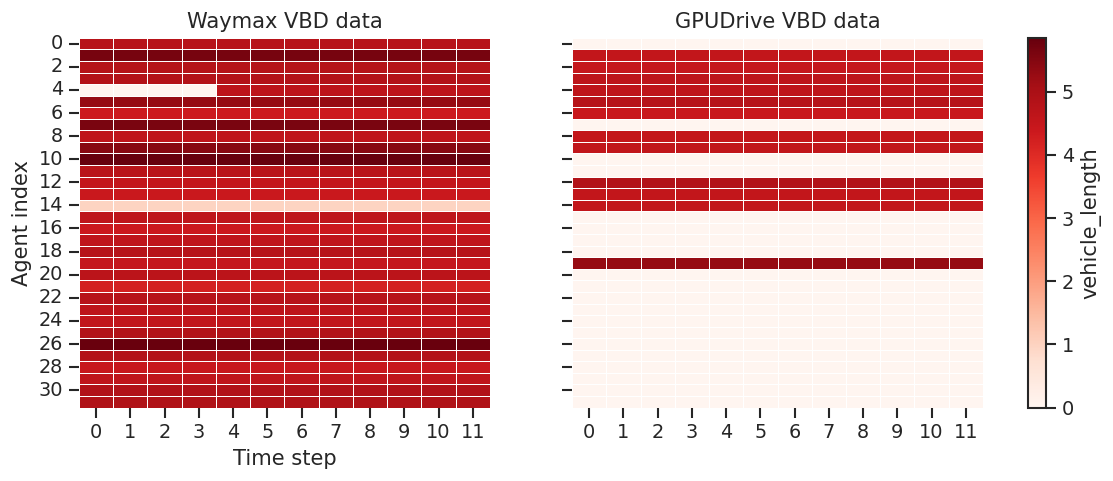

In [79]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data,
    array_name='agents_history', 
    index=5, 
    feature_name=feature_names[5]
)

#### Vehicle width

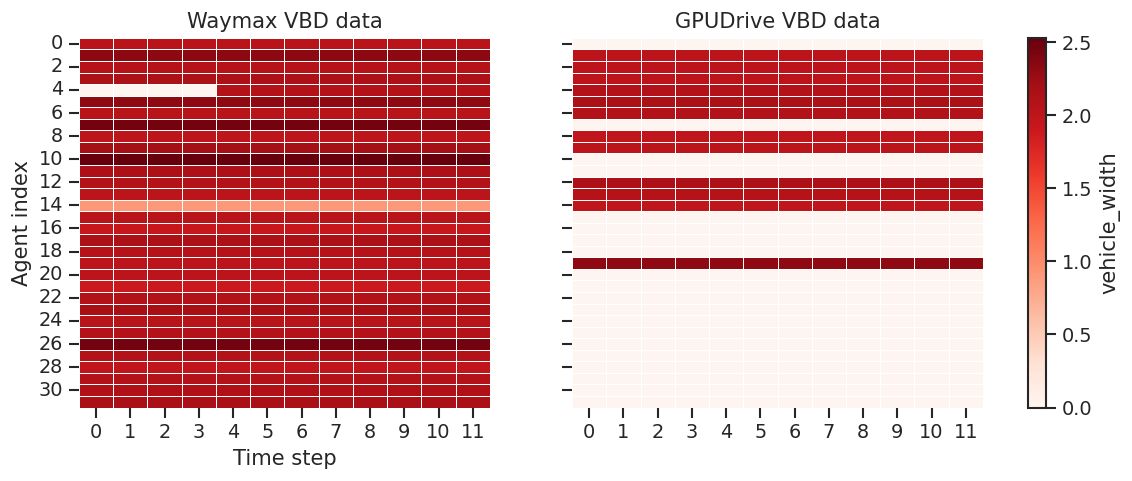

In [80]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_history',
    index=6, 
    feature_name=feature_names[6]
)

#### Vehicle height

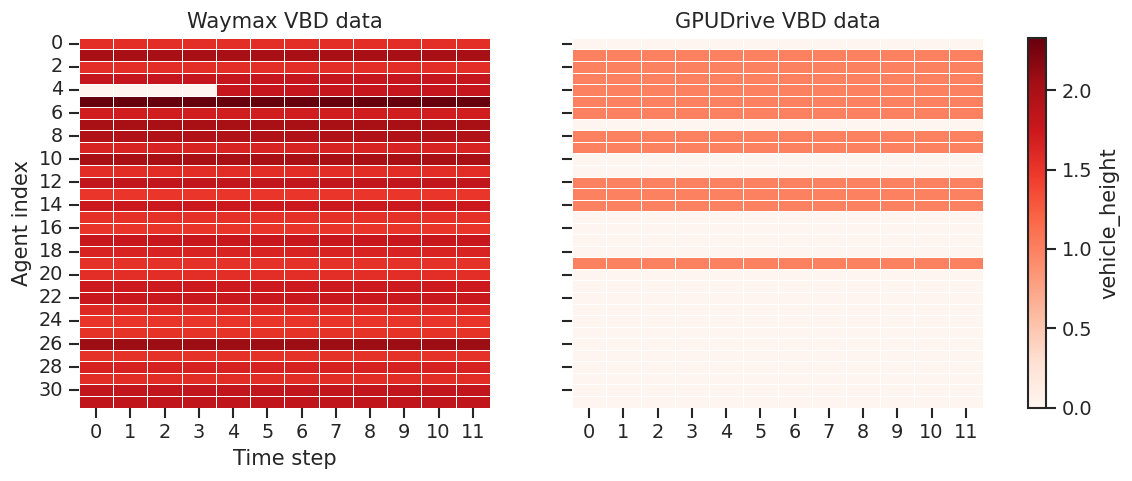

In [81]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_history',
    index=7, 
    feature_name=feature_names[7]
)

### ✅ 2. Agents interested 


- What:
    - Encodes what we control. `10` means we control the agent; `1` means we don't control the agent (10 is an arbitrary value adopted from VBD code)
- Notes:
    - In GPUDrive we control 12 agents whereas in waymax its 5 (this doesn't have to be a problem though)
    - Order is different but that shouldn't matter for the model performance
- Checklist:
    - ✔️: Values aligned? (1, 10) -> yes



In [82]:
waymax_vbd_data['agents_interested'].shape, gpudrive_vbd_data['agents_interested'].squeeze(0).shape

((32,), (32,))

In [64]:
waymax_vbd_data['agents_interested'], (waymax_vbd_data['agents_interested'] == 10).sum()

(array([10, 10, 10, 10, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       dtype=int32),
 5)

In [65]:
gpudrive_vbd_data['agents_interested'].astype(int).squeeze(0), (gpudrive_vbd_data['agents_interested'] == 10).sum()

(array([ 1, 10, 10, 10, 10, 10, 10,  1, 10, 10,  1,  1, 10, 10, 10,  1,  1,
         1,  1, 10,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1]),
 12)

In [66]:
np.equal(gpudrive_vbd_data['agents_interested'].astype(int).squeeze(0), waymax_vbd_data['agents_interested']), np.equal(gpudrive_vbd_data['agents_interested'].astype(int).squeeze(0), waymax_vbd_data['agents_interested']).sum()

(array([False,  True,  True,  True,  True, False, False,  True, False,
        False,  True,  True, False, False, False,  True,  True,  True,
         True, False,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True]),
 23)

### ✅ 3. Agents type

- What:
    - Encodes object type: `metadata.object_types`, can be `(Unset=0, Vehicle=1, Pedestrian=2, Cyclist=3, Other=4)`
- Notes:
    - I don't understand why none of the VBD elements are 0, I mean, some of these must be padding agents.
    - Other than that, things look good
- Checklist:
    - ✔️ Check types (we see a 1 and a 2 in both arrays)

In [67]:
waymax_vbd_data['agents_type'].shape, gpudrive_vbd_data['agents_type'].squeeze(0).shape

((32,), (32,))

In [68]:
waymax_vbd_data['agents_type']

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [69]:
gpudrive_vbd_data['agents_type']

array([[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

### 4. Agents future

- Shape: `(32, 80, 5) ; (max_controlled_agents, remaining_timesteps, features)`
- What:
    - The _log playback_ futures ($t=11$ to $t=91$) of the humans 
    - Q: How is this used in the VBD model?
- Notes:
    - ..
    - 
- Checklist:
    - ✔️ Is the order of the features the same?


In [83]:
waymax_vbd_data['agents_future'].shape, gpudrive_vbd_data['agents_future'].squeeze(0).shape

((32, 80, 5), (32, 80, 5))

In [84]:
agents_future_feat_names = {
    0: "x",
    1: "y",
    2: "yaw",
    3: "vel_x",
    4: "vel_y",
}

In [88]:
waymax_vbd_data['agents_future'][:, :, 0]

array([[8485.417,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [8495.715,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [8499.601,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       ...,
       [8495.525,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [8528.429,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ],
       [8443.709,    0.   ,    0.   , ...,    0.   ,    0.   ,    0.   ]],
      dtype=float32)

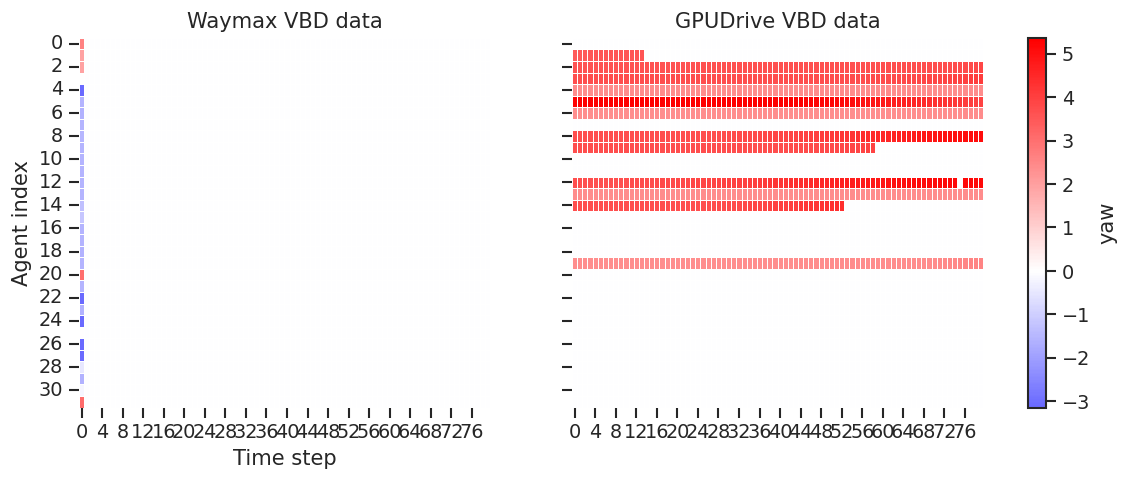

In [87]:
make_heatmaps(
    waymax_vbd_data, 
    gpudrive_vbd_data, 
    array_name='agents_future',
    index=2, 
    feature_name=agents_future_feat_names[2]
)

### 5. Traffic light points

In [121]:
waymax_vbd_data['traffic_light_points'].shape, gpudrive_vbd_data['traffic_light_points'].squeeze(0).shape

((16, 3), (16, 3))

In [ ]:
waymax_vbd_data['traffic_light_points'], gpudrive_vbd_data['traffic_light_points']

### 6. Polylines

- [p_x, p_y, heading, traffic_light_state, lane_type]

In [130]:
waymax_vbd_data['polylines'].shape, gpudrive_vbd_data['polylines'].squeeze(0).shape

((256, 30, 5), (256, 30, 5))

In [131]:
# Can't be compared directly
waymax_vbd_data['polylines'][:, :, 0], gpudrive_vbd_data['polylines'].squeeze(0)[:, :, 0]

(array([[8478.251 , 8477.762 , 8477.271 , ..., 8462.099 , 8461.609 ,
         8460.631 ],
        [8501.151 , 8501.0625, 8500.936 , ..., 8484.239 , 8483.419 ,
         8482.19  ],
        [8478.13  , 8479.614 , 8481.1   , ..., 8521.192 , 8522.677 ,
         8524.657 ],
        ...,
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ],
        [   0.    ,    0.    ,    0.    , ...,    0.    ,    0.    ,
            0.    ]], dtype=float32),
 array([[-80.34973, -80.34973, -80.34973, ..., -46.41858, -46.41858,
         -46.68335],
        [174.     , 174.     , 174.     , ..., 167.73218, 167.73218,
         166.2826 ],
        [166.37476, 166.37476, 166.37476, ..., 166.37476, 166.37476,
         166.37476],
        ...,
        [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
           0.     ],
        [  0.     ,   0.     ,   0.     , ...,   0.     ,

In [132]:
waymax_vbd_data['polylines'][:, :, 4], gpudrive_vbd_data['polylines'].squeeze(0)[:, :, 4]

(array([[2., 2., 2., ..., 2., 2., 2.],
        [6., 6., 6., ..., 6., 6., 6.],
        [2., 2., 2., ..., 2., 2., 2.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 array([[15., 15., 15., ..., 15., 15., 15.],
        [15., 15., 15., ..., 15., 15., 15.],
        [15., 15., 15., ..., 15., 15., 15.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32))

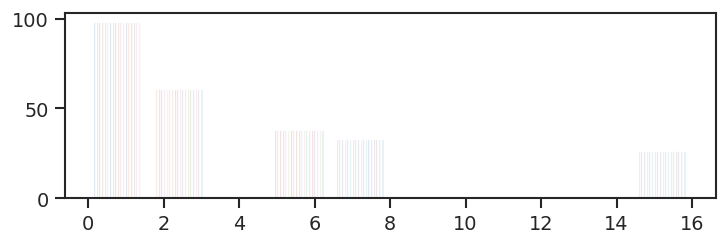

In [135]:
plt.hist(waymax_vbd_data['polylines'][:, :, 4]);

### Old

In [25]:
df_polylines_waymax = pd.DataFrame({
    'x': scenario.roadgraph_points.x,
    'y': scenario.roadgraph_points.y,
    'yaw_x': scenario.roadgraph_points.dir_x,
    'yaw_y': scenario.roadgraph_points.dir_y,
    'type': scenario.roadgraph_points.types,
    #'tl_state': scenario.log_traffic_light.state[:, 0],
    'simulator': 'waymax'
})

df_polylines_waymax.head()

,x,y,yaw_x,yaw_y,type,simulator
0,4259.661621,11798.491211,0.999987,0.004590,15,waymax
1,4260.161133,11798.493164,0.999988,0.004493,15,waymax
2,4260.660645,11798.495117,0.999988,0.004396,15,waymax
3,4261.159668,11798.498047,0.999989,0.004300,15,waymax
4,4261.659180,11798.500000,0.999989,0.004203,15,waymax


In [38]:
# Note: In contrast to Waymax, these have already been filtered for proximity to vehicles
gpudrive_global_roadgraph = gpudrive_env.sim.map_observation_tensor().to_torch().squeeze(0)

gpudrive_global_roadgraph.shape # agents, k_top_roadpoints, features

torch.Size([2000, 7])

In [39]:
df_polylines_gpudrive = pd.DataFrame({
    'x': gpudrive_global_roadgraph[:, 0].flatten(),
    'y': gpudrive_global_roadgraph[:, 1].flatten(),
    'scale': gpudrive_global_roadgraph[:, 3].flatten(),
    'heading': gpudrive_global_roadgraph[:, 4].flatten(), # Note: Placeholder, GPUDrive doesn't have a "yaw_y"
    'type': gpudrive_global_roadgraph[:, 6].flatten(),
    'simulator': 'gpudrive'
})

In [40]:
# sns.histplot(df_polylines_gpudrive['type'], discrete=True, alpha=0.5, label='GPUDrive')
# sns.histplot(df_waymax_vbd['type'], discrete=True, alpha=0.5, label='VDB', )
# plt.legend()
# plt.xticks(range(20));

# No #15 or #16 in GPUDrive -> why vehicles are colliding with the road

In [41]:
waymax_vbd_data.keys()

dict_keys(['agents_history', 'agents_interested', 'agents_type', 'agents_future', 'traffic_light_points', 'polylines', 'polylines_valid', 'relations', 'agents_id', 'anchors'])

In [42]:
waymax_vbd_data['polylines'].shape

(256, 30, 5)

In [43]:
waymax_vbd_data['polylines'][]

SyntaxError: invalid syntax (2887505685.py, line 1)

In [44]:
waymax_vbd_data['polylines'].shape

(256, 30, 5)

In [45]:
df_waymax_vbd = pd.DataFrame({
    'x': waymax_vbd_data['polylines'][:, :, 0].flatten(),
    'y': waymax_vbd_data['polylines'][:, :, 1].flatten(),   
    'yaw_x': waymax_vbd_data['polylines'][:, :, 2].flatten(),
    'yaw_y': waymax_vbd_data['polylines'][:, :, 3].flatten(),
    'type': waymax_vbd_data['polylines'][:, :, 4].flatten(),    
    'simulator': 'waymax_vbd'
})

In [46]:
df = pd.concat([df_polylines_gpudrive, df_polylines_waymax, df_waymax_vbd])

In [47]:
#df.groupby('simulator').describe().T

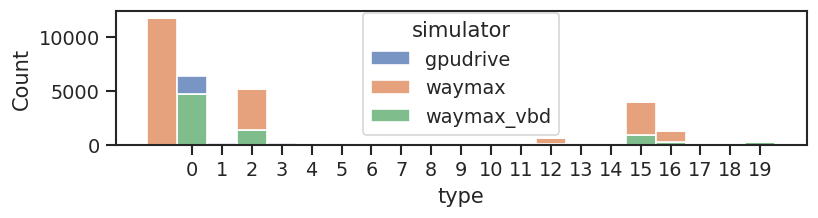

In [48]:
sns.histplot(df, x='type', hue='simulator', multiple='stack', bins=21, discrete=True,);
plt.tight_layout()
plt.xticks(range(20));

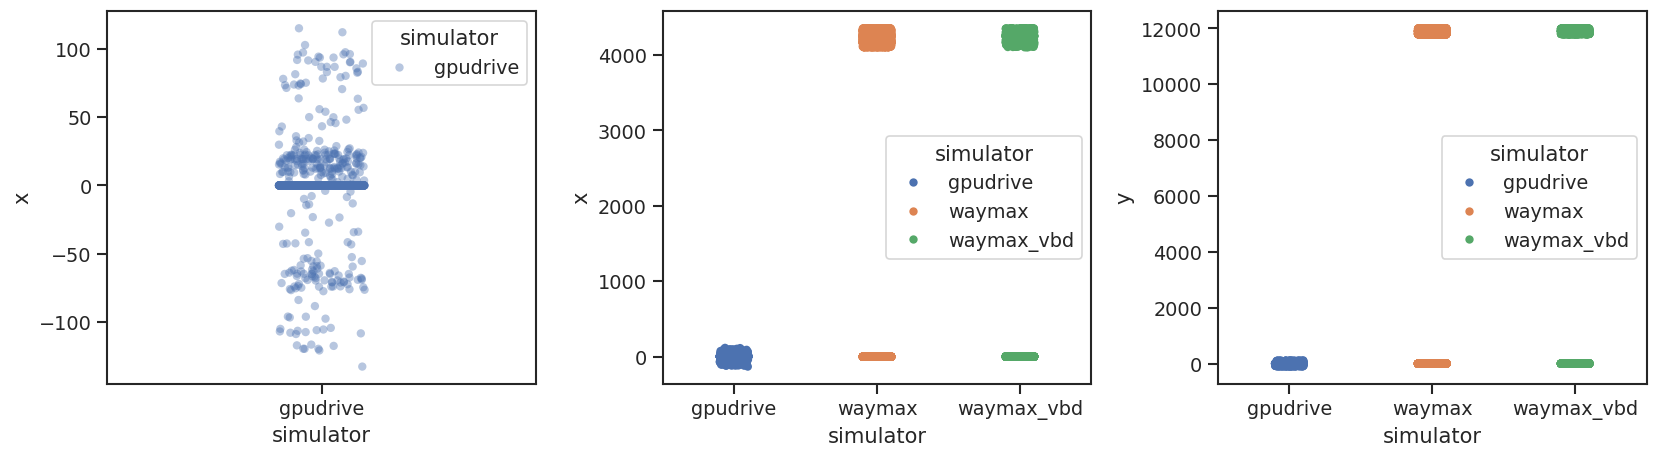

In [50]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.stripplot(df_polylines_gpudrive, x='simulator', y='x', hue='simulator', ax=axs[0], alpha=0.4, legend=True)

sns.stripplot(df, x='simulator', y='x', hue='simulator', ax=axs[1], legend=True)

sns.stripplot(df, x='simulator', y='y', hue='simulator', ax=axs[2], legend=True)

plt.tight_layout()

AttributeError: 'RoadgraphPoints' object has no attribute 'dir'

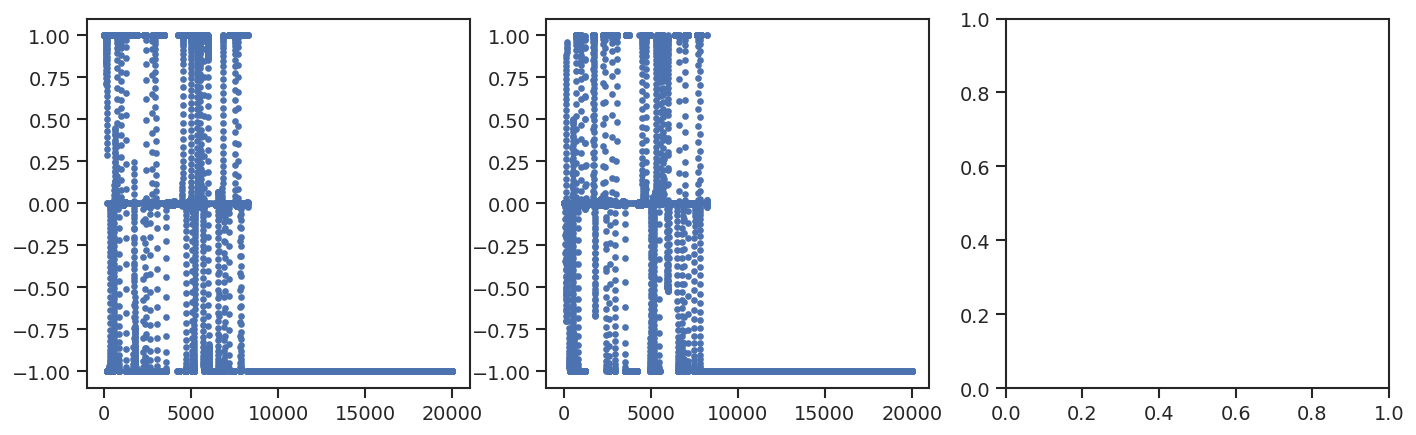

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].plot(scenario.roadgraph_points.dir_x, '.', label='x')
axs[1].plot(scenario.roadgraph_points.dir_y, '.', label='y')
axs[2].plot(scenario.roadgraph_points.dir, '.', label='z')

plt.tight_layout()